In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("./cardio_train.csv",sep=";")

In [3]:
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [4]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
df.shape

(70000, 13)

/Users/rishimane/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Train shape: (49000, 12)  | Test shape: (21000, 12)


/Users/rishimane/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔹 Fusion Model 1 (RF+ANN) | p=0.500, q=0.500
Accuracy=0.7133 | F1=0.7045 | AUC=0.7718
[[7800 2706]
 [3315 7179]]
              precision    recall  f1-score   support

           0       0.70      0.74      0.72     10506
           1       0.73      0.68      0.70     10494

    accuracy                           0.71     21000
   macro avg       0.71      0.71      0.71     21000
weighted avg       0.71      0.71      0.71     21000



/Users/rishimane/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



🔹 Fusion Model 2 (DT+AdaBoost) | p=0.500, q=0.500
Accuracy=0.7288 | F1=0.7273 | AUC=0.7927
[[7707 2799]
 [2897 7597]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     10506
           1       0.73      0.72      0.73     10494

    accuracy                           0.73     21000
   macro avg       0.73      0.73      0.73     21000
weighted avg       0.73      0.73      0.73     21000


🔹 Fusion Model 3 (SVM+LR) | p=0.500, q=0.500
Accuracy=0.7208 | F1=0.7147 | AUC=0.7822
[[7795 2711]
 [3152 7342]]
              precision    recall  f1-score   support

           0       0.71      0.74      0.73     10506
           1       0.73      0.70      0.71     10494

    accuracy                           0.72     21000
   macro avg       0.72      0.72      0.72     21000
weighted avg       0.72      0.72      0.72     21000


=== SUMMARY RESULTS ===
         Model  Accuracy        F1       AUC
0       RF+ANN  0.713286  0.704549  0.77178

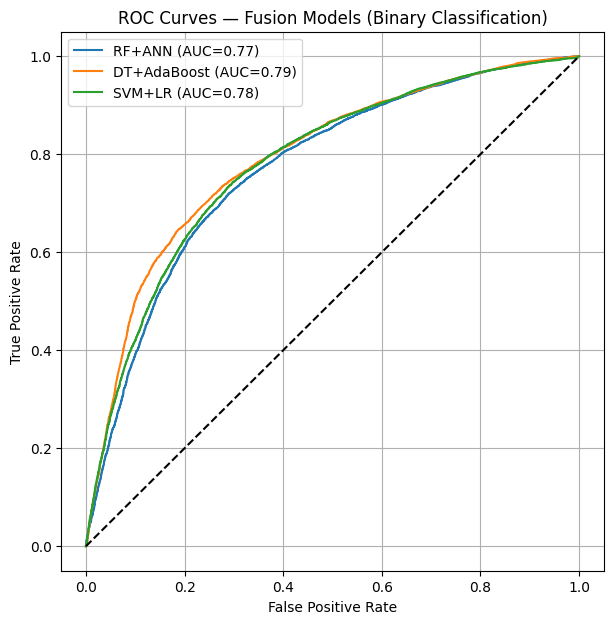

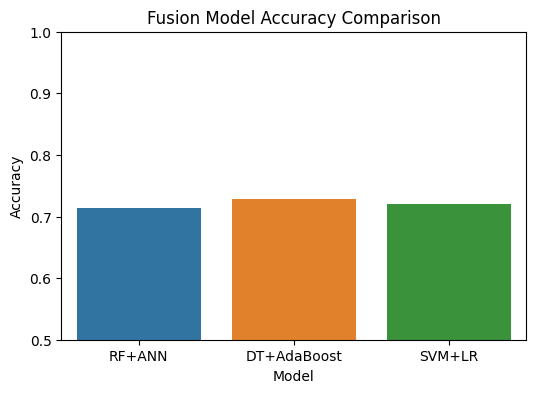

In [6]:
# =========================================================
# CARDIOVASCULAR DISEASE SEVERITY PREDICTION (BINARY FUSION MODELS)
# Fusion Models:
#   1. Random Forest + ANN
#   2. Decision Tree + AdaBoost
#   3. SVM + Logistic Regression
# =========================================================

# ---------- IMPORTS ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc, f1_score, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from scipy.optimize import minimize

# =========================================================
# 1. DATA LOADING & PREPROCESSING
# =========================================================
df = pd.read_csv("cardio_train.csv", sep=';')

# --- basic cleaning ---
df.drop_duplicates(inplace=True)
df.drop(columns=['id'], inplace=True, errors='ignore')

# Convert age from days → years
df['age'] = (df['age'] / 365).astype(int)

# Compute BMI (useful for interpretability)
df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2)

# Define features and target
X = df.drop(columns=['cardio'])
y = df['cardio']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, " | Test shape:", X_test.shape)

# =========================================================
# 2. HELPER: Adaptive Fusion Weight Optimization
# =========================================================
def optimize_fusion_weight(y_true, proba1, proba2):
    """Optimize fusion weight p using accuracy as objective."""
    def loss_func(w):
        w = w[0]
        mixed = w * proba1 + (1 - w) * proba2
        preds = (mixed >= 0.5).astype(int)
        return -accuracy_score(y_true, preds)  # minimize negative accuracy

    res = minimize(loss_func, [0.5], bounds=[(0, 1)], method='L-BFGS-B')
    return res.x[0]

# =========================================================
# 3. FUSION MODEL 1 — RANDOM FOREST + ANN
# =========================================================
def fusion_rf_ann(X_train, X_test, y_train, y_test):
    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    proba_rf = rf.predict_proba(X_test)[:, 1]

    # ANN
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    ann = Sequential([
        Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    ann.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    ann.fit(X_train_scaled, y_train, batch_size=16, epochs=30, verbose=0)

    proba_ann = ann.predict(X_test_scaled, verbose=0).flatten()

    # Optimize weight
    best_p = optimize_fusion_weight(y_test, proba_rf, proba_ann)
    q = 1 - best_p
    mixed = proba_rf * best_p + proba_ann * q
    preds = (mixed >= 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc_val = roc_auc_score(y_test, mixed)

    print(f"\n🔹 Fusion Model 1 (RF+ANN) | p={best_p:.3f}, q={q:.3f}")
    print(f"Accuracy={acc:.4f} | F1={f1:.4f} | AUC={auc_val:.4f}")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))

    fpr, tpr, _ = roc_curve(y_test, mixed)
    return acc, f1, auc_val, fpr, tpr, 'RF+ANN'

# =========================================================
# 4. FUSION MODEL 2 — DECISION TREE + ADABOOST
# =========================================================
def fusion_tree_adaboost(X_train, X_test, y_train, y_test):
    dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=42)
    dt.fit(X_train, y_train)
    proba_dt = dt.predict_proba(X_test)[:, 1]

    ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.05, random_state=42)
    ada.fit(X_train, y_train)
    proba_ada = ada.predict_proba(X_test)[:, 1]

    best_p = optimize_fusion_weight(y_test, proba_dt, proba_ada)
    q = 1 - best_p
    mixed = proba_dt * best_p + proba_ada * q
    preds = (mixed >= 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc_val = roc_auc_score(y_test, mixed)

    print(f"\n🔹 Fusion Model 2 (DT+AdaBoost) | p={best_p:.3f}, q={q:.3f}")
    print(f"Accuracy={acc:.4f} | F1={f1:.4f} | AUC={auc_val:.4f}")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))

    fpr, tpr, _ = roc_curve(y_test, mixed)
    return acc, f1, auc_val, fpr, tpr, 'DT+AdaBoost'

# =========================================================
# 5. FUSION MODEL 3 — SVM + LOGISTIC REGRESSION
# =========================================================
def fusion_svm_lr(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svm = SVC(probability=True, C=1.0, gamma='scale', random_state=42)
    svm.fit(X_train_scaled, y_train)
    proba_svm = svm.predict_proba(X_test_scaled)[:, 1]

    lr = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000, random_state=42)
    lr.fit(X_train_scaled, y_train)
    proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

    best_p = optimize_fusion_weight(y_test, proba_svm, proba_lr)
    q = 1 - best_p
    mixed = proba_svm * best_p + proba_lr * q
    preds = (mixed >= 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc_val = roc_auc_score(y_test, mixed)

    print(f"\n🔹 Fusion Model 3 (SVM+LR) | p={best_p:.3f}, q={q:.3f}")
    print(f"Accuracy={acc:.4f} | F1={f1:.4f} | AUC={auc_val:.4f}")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))

    fpr, tpr, _ = roc_curve(y_test, mixed)
    return acc, f1, auc_val, fpr, tpr, 'SVM+LR'

# =========================================================
# 6. RUN ALL THREE FUSIONS
# =========================================================
results = []

for func in [fusion_rf_ann, fusion_tree_adaboost, fusion_svm_lr]:
    results.append(func(X_train, X_test, y_train, y_test))

# Convert results to DataFrame
results_df = pd.DataFrame([
    {'Model': name, 'Accuracy': acc, 'F1': f1, 'AUC': auc_val}
    for (acc, f1, auc_val, fpr, tpr, name) in results
])
print("\n=== SUMMARY RESULTS ===")
print(results_df)

# =========================================================
# 7. PLOT ROC CURVES
# =========================================================
plt.figure(figsize=(7,7))
for (acc, f1, auc_val, fpr, tpr, name) in results:
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc_val:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curves — Fusion Models (Binary Classification)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# =========================================================
# 8. BAR CHART COMPARISON
# =========================================================
plt.figure(figsize=(6,4))
sns.barplot(x='Model', y='Accuracy', data=results_df, hue='Model', dodge=False)
plt.title('Fusion Model Accuracy Comparison')
plt.ylim(0.5, 1.0)
plt.show()
